In [1]:
import pandas as pd
import numpy as np
from arch import arch_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Import DataLoader from your SARIMAX.py file
from SARIMAX import *

In [2]:
# Step 1: Load and Preprocess Data
file_path = "/Users/alonclausen/Desktop/Studie/Kandidat/Seminar/SEMINARFIN/fulldata.csv"
loader = DataLoader(file_path, use_temp=True, use_wind=False, use_oil=False, use_gas=False)
loader.load_data()
spot_price, exog_data = loader.preprocess_data()

# Compute returns (log-returns)
returns = np.log(spot_price).diff().dropna()


# Split data into training and test
train_end = '2024-07-31'
train_data = returns.loc[:train_end].dropna()
test_data = returns.loc[train_end:].dropna()

# Select just the temperature column as exogenous variable
temp_train = exog_data.loc[train_data.index, ['avg_temp']]

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [3]:
# Define temp_window using temp_train
data_window = train_data.loc['2012-01-01':'2024-07-31']
temp_window = temp_train.loc[data_window.index]

# Fit the model with ARX mean and exog=temp_window
base_model = arch_model(
    data_window,
    mean='ARX', 
    lags=1,
    vol='GARCH', p=1, q=1, dist='normal',
    x=temp_window  
)

base_results = base_model.fit(disp='off')
params = base_results.params

In [4]:
forecasted_returns = []
test_index = test_data.index

for current_time in test_index:
    past_time = current_time - pd.Timedelta(hours=24)
    data_window = returns.loc[:past_time].dropna()
    if len(data_window) == 0:
        forecasted_returns.append(np.nan)
        continue

    # Get exogenous data for the data_window
    temp_window = exog_data.loc[data_window.index, ['avg_temp']]

    model = arch_model(
    data_window,
    mean='ARX', 
    lags=1,
    vol='GARCH', p=1, q=1, dist='normal',
    x=temp_window  
    )

    fixed_results = model.fix(params)

    # Get exogenous data for the forecast horizon
    exog_forecast = exog_data.loc[current_time:current_time + pd.Timedelta(hours=24), ['avg_temp']].iloc[:1]
    
    forecast = fixed_results.forecast(horizon=1, start=data_window.index[-1], reindex=False, x=exog_forecast)
    forecasted_returns.append(forecast.mean['h.1'].iloc[-1])

forecasted_returns = pd.Series(forecasted_returns, index=test_index)
forecasted_returns = forecasted_returns.dropna()




In [5]:
# Step 4: Evaluate the Forecasts
common_index = test_data.index.intersection(forecasted_returns.index)
actual = test_data.loc[common_index]
pred = forecasted_returns.loc[common_index].fillna(0)  # If there are NaNs, fill with 0 for evaluation

mae = mean_absolute_error(actual, pred)
rmse = np.sqrt(mean_squared_error(actual, pred))
print("MAE:", mae)
print("RMSE:", rmse)


MAE: 0.2702853252605584
RMSE: 0.6522630215395991


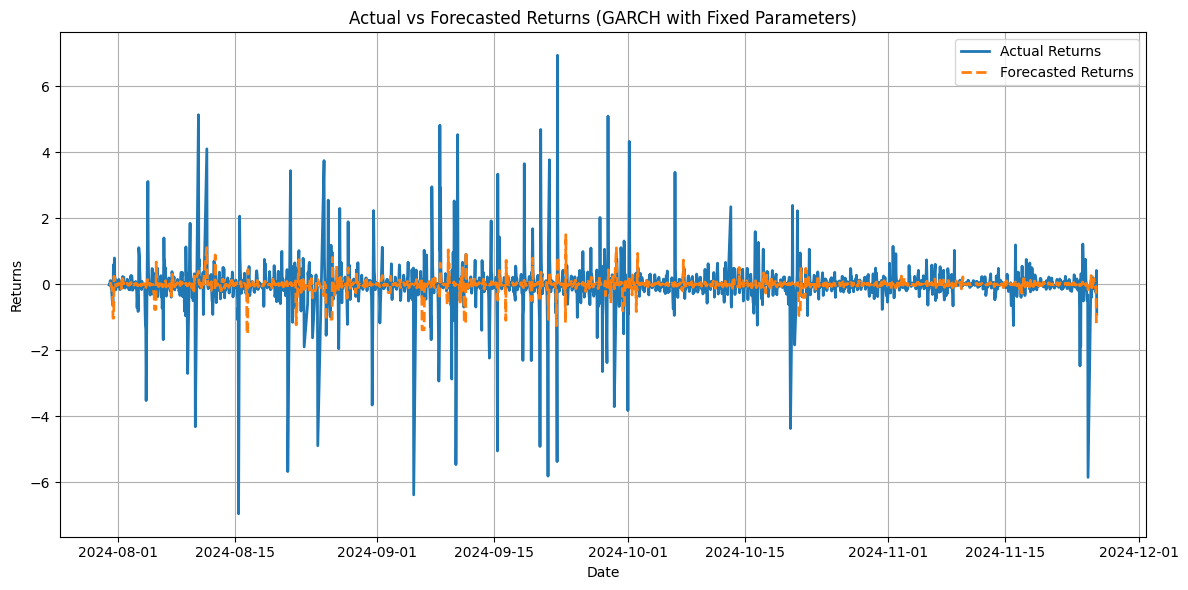

In [6]:
# Step 5: Plot Actual vs Forecasted Returns
plt.figure(figsize=(12,6))
plt.plot(actual.index, actual, label='Actual Returns', linewidth=2)
plt.plot(pred.index, pred, label='Forecasted Returns', linestyle='--', linewidth=2)
plt.title('Actual vs Forecasted Returns (GARCH with Fixed Parameters)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

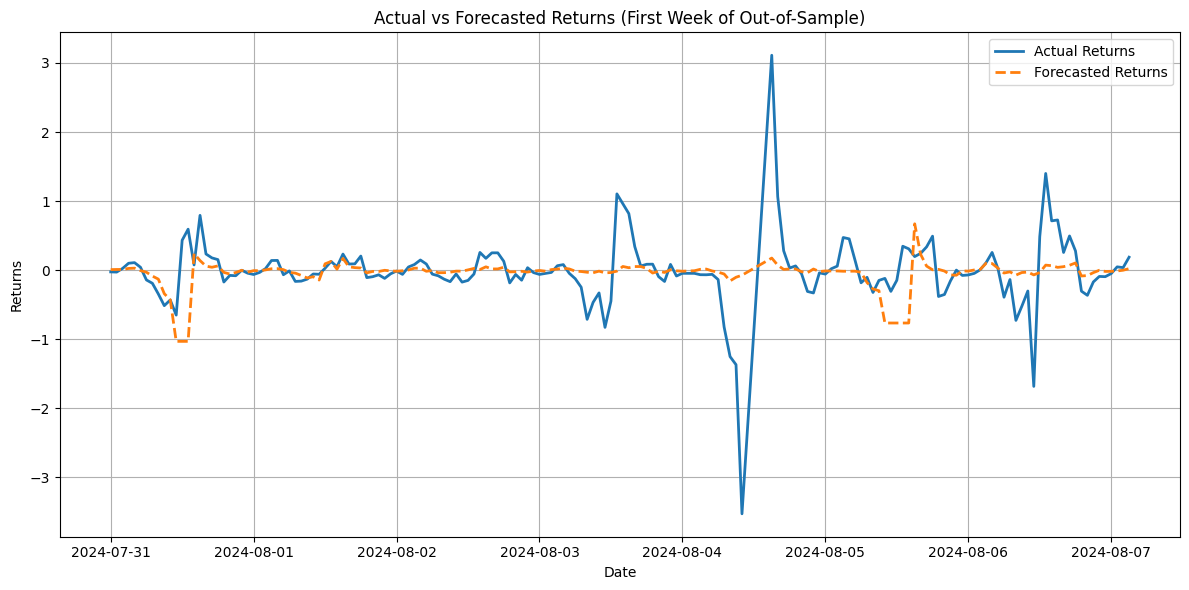

In [8]:
# Select the first week of the out-of-sample period
first_week_index = test_index[:24*7]  # 24 hours * 7 days
actual_first_week = actual.loc[first_week_index]
forecasted_first_week = forecasted_returns.loc[first_week_index]

# Plot the actual and forecasted values
plt.figure(figsize=(12,6))
plt.plot(actual_first_week.index, actual_first_week, label='Actual Returns', linewidth=2)
plt.plot(forecasted_first_week.index, forecasted_first_week, label='Forecasted Returns', linestyle='--', linewidth=2)
plt.title('Actual vs Forecasted Returns (First Week of Out-of-Sample)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()